In [1]:
!pip -q install pydicom torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 72.3 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
from glob import glob
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
import torchmetrics as torchmetrics
import torchvision
import torch.nn as nn
import torch
import seaborn as sns

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/rsna-pneumonia-detection-challenge.zip -d /content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped

In [3]:
labels=pd.read_csv('/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/stage_2_train_labels.csv')

In [4]:
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [5]:
labels=labels.drop_duplicates('patientId')

In [6]:
ROOT_PATH=Path('/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/stage_2_train_images/')
SAVE_PATH=Path('/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/stage_2_images_processed/')
LABEL=Path('/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/stage_2_train_labels.csv')

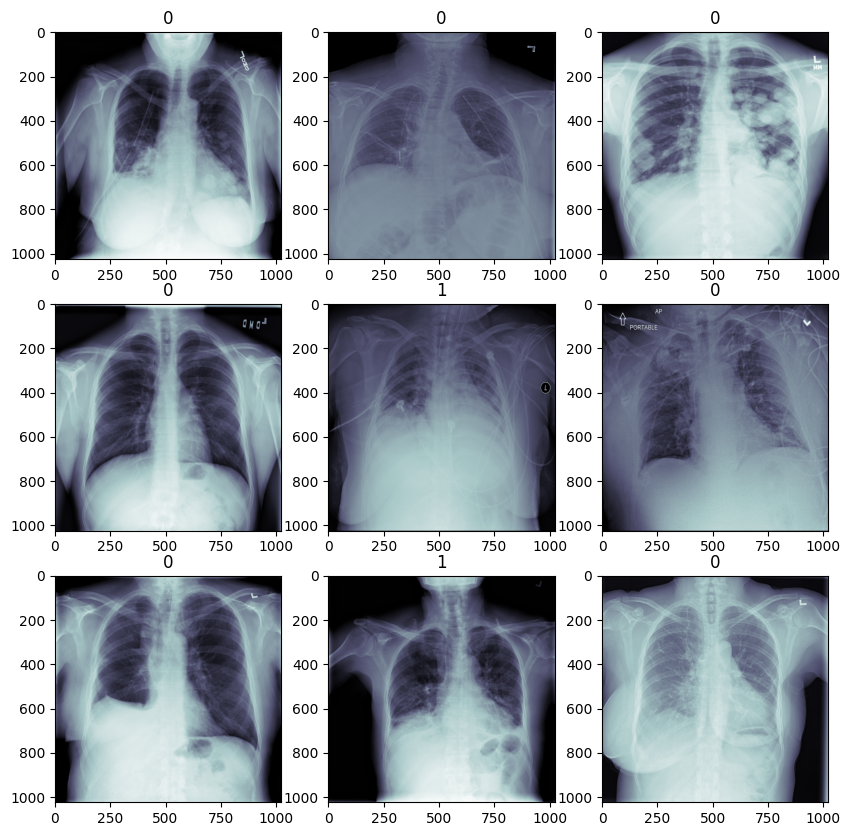

In [7]:
fig, axis=plt.subplots(3,3, figsize=(10,10))
c=0

for i in range(3):
  for j in range(3):
    patient_id=labels.patientId.iloc[c]
    dcm_path=ROOT_PATH/patient_id
    dcm_path=dcm_path.with_suffix('.dcm')
    dcm=pydicom.dcmread(dcm_path)
    img=dcm.pixel_array

    label=labels['Target'].iloc[c]

    axis[i][j].imshow(img,cmap='bone')
    axis[i][j].set_title(label)
    c+=1

In [8]:
class PneumoniaDataset(Dataset):

  def __init__(self, labels, root_path, transform=None):
    self.labels=pd.read_csv(labels)
    self.labels=self.labels.drop_duplicates('patientId')
    self.targets=self.labels.reset_index(drop=True)
    self.root_path=root_path
    self.transform=transform


  def __getitem__(self, index):

      patient_id=self.labels.patientId.iloc[index]
      dcm_path=self.root_path/patient_id
      dcm_path=dcm_path.with_suffix('.dcm')
      dcm=pydicom.dcmread(dcm_path)
      img=dcm.pixel_array/255

      if self.transform is not None:
        img=self.transform(img)

      label=self.labels.Target.iloc[index]
      return img, torch.tensor(label,dtype=torch.float32)

  def __len__(self):
    return len(self.labels)






In [9]:

normalization=transforms.Normalize(mean=0.5,std=0.5)
train_transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32),
     transforms.Resize((224,224)),
     normalization,
     transforms.RandomAffine(degrees=(-5,5),translate=(0,0.05),scale=(0.9,1.1)),
     transforms.RandomResizedCrop(224,scale=(0.35,1))

    ]
)

val_transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32),
     transforms.Resize((224,224)),
     normalization
    ]
)

In [10]:

full_dataset = PneumoniaDataset(labels=LABEL, root_path=ROOT_PATH)

train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size

test_size=int(0.1*len(full_dataset))
val_size=val_size-test_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform


batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


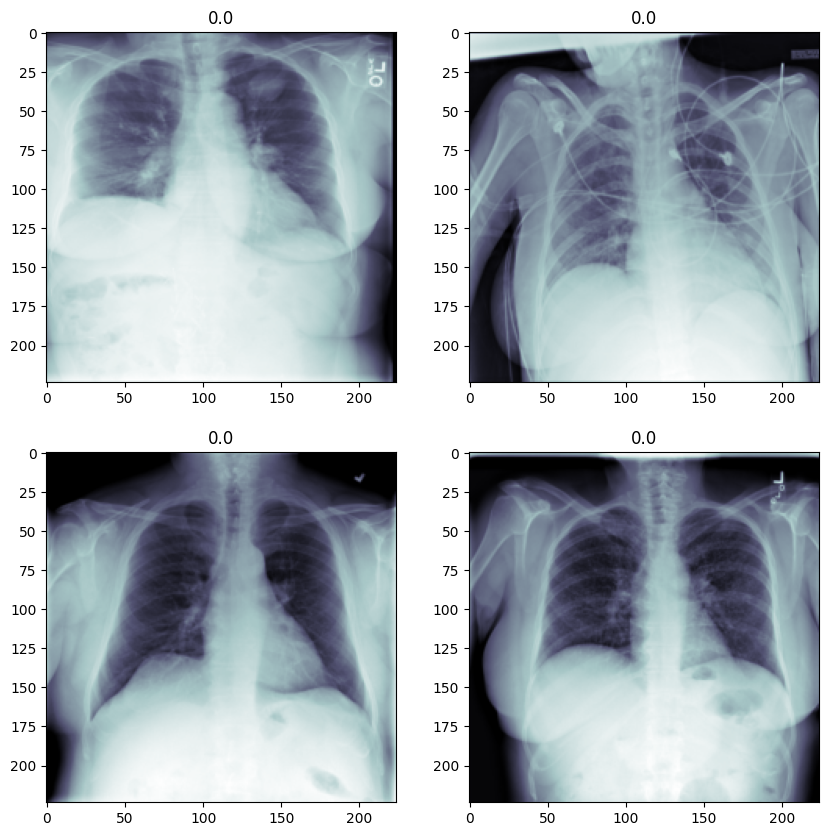

In [31]:
fig, axis=plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    random_index=np.random.randint(0,1000)
    x_ray,label=train_dataset[random_index]
    axis[i][j].imshow(x_ray[0],cmap='bone')
    axis[i][j].set_title(label.item())

In [39]:
class PneumoniaModel(nn.Module):

  def __init__(self, num_classes=1 ):

    super().__init__()

    self.model=torchvision.models.resnet50(pretrained=True)
    self.model.conv1=nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
    self.model.fc=nn.Linear(in_features=self.model.fc.in_features,out_features=num_classes,bias=True)

  def forward(self, x):
      x=self.model(x)
      return x

In [42]:
model=PneumoniaModel()

model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [12]:
def train(model, train_loader, optimizer,loss_fn, device):

  model.train()
  total_loss=0

  for image, label in tqdm(train_loader,desc="Training"):

    image=image.to(device)
    label=label.to(device)

    optimizer.zero_grad()

    predictions=model(image)
    loss=loss_fn(predictions,  label.unsqueeze(1))

    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(train_loader)


def evaluate(model, val_loader,loss_fn, device):

  model.eval()
  total_loss=0
  running_acc=0

  with torch.no_grad():
    for image, label in tqdm(val_loader,desc="evaluation"):

      image=image.to(device)
      label=label.to(device)

      predictions=model(image)

      loss=loss_fn(predictions, label.unsqueeze(1))


      total_loss+=loss.item()

      accuracy=torchmetrics.Accuracy(task='binary')(predictions.squeeze(1).cpu(), label.cpu().int())
      running_acc+=accuracy.item()

    validate_acc=running_acc/len(val_loader)
    epoch_loss=total_loss/len(val_loader)

    return epoch_loss, validate_acc



In [13]:
def main(model, epoch,learning_rate ):

  training_loss=[]
  validation_loss=[]
  validation_acc=[]

  device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  num_epochs=epoch

  optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss_fn=nn.BCEWithLogitsLoss()
  total_steps = len(train_loader) * num_epochs


  for epoch in range(epoch):
    print(f"Epoch {epoch+1}")
    train_loss=train(model, train_loader,  optimizer,loss_fn, device)
    val_loss, val_acc=evaluate(model, val_loader,loss_fn, device)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)

    print(f'Epoch {epoch+1}/{epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} Val accuracy  {val_acc:.4f}')





In [80]:
if __name__ == "__main__":
  model=PneumoniaModel()
  feature_extractor=torchvision.models.ResNet50_Weights.DEFAULT
  model.load_state_dict(torch.load('/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/model.pth'))
  main(model ,epoch=5, learning_rate=5e-5)


  torch.save(model.state_dict(),  '/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/model.pth')
  print('model saved')




/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1


Training:   0%|          | 0/584 [00:00<?, ?it/s]

evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Epoch 1/0 | Train Loss: 0.4036 | Val Loss: 0.3707 Val accuracy  0.8352
Epoch 2


Training:   0%|          | 0/584 [00:00<?, ?it/s]

evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Epoch 2/1 | Train Loss: 0.3543 | Val Loss: 0.3663 Val accuracy  0.8423
Epoch 3


Training:   0%|          | 0/584 [00:00<?, ?it/s]

evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Epoch 3/2 | Train Loss: 0.2929 | Val Loss: 0.4130 Val accuracy  0.8135
Epoch 4


Training:   0%|          | 0/584 [00:00<?, ?it/s]

evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Epoch 4/3 | Train Loss: 0.1921 | Val Loss: 0.4537 Val accuracy  0.8122
Epoch 5


Training:   0%|          | 0/584 [00:00<?, ?it/s]

evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Epoch 5/4 | Train Loss: 0.1016 | Val Loss: 0.6517 Val accuracy  0.8147
model saved


In [15]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=PneumoniaModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/model.pth'))
model.to(device)

preds=[]
labels=[]
with torch.no_grad():
  for image, label in tqdm(test_loader,desc="testing"):

    image=image.to(device)
    label=label.to(device)

    predictions=torch.sigmoid(model(image))
    preds.append(predictions.squeeze(1).cpu())
    labels.append(label.cpu())

preds=torch.cat(preds)
labels=torch.cat(labels).int()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]


testing:   0%|          | 0/167 [00:00<?, ?it/s]

Accuracy: 0.9272863864898682
Precision: 0.85467129945755
Recall: 0.8178808093070984
F1 Score: 0.8358713984489441
Confusion Matrix: tensor([[1980,   84],
        [ 110,  494]])


<Axes: >

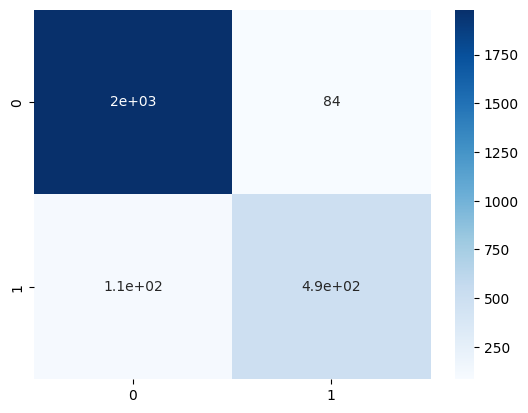

In [16]:
acc=torchmetrics.Accuracy(task='binary')(preds, labels)
precision=torchmetrics.Precision(task='binary')(preds, labels)
recall=torchmetrics.Recall(task='binary')(preds, labels)
f1=torchmetrics.F1Score(task='binary')(preds, labels)
cm=torchmetrics.ConfusionMatrix(task='binary')(preds, labels)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: {cm}")

sns.heatmap(cm, annot=True, cmap='Blues')

**Using CAM**

In [87]:


class PneumoniaModel(nn.Module):

  def __init__(self,num_classes=1):
    super().__init__()


    self.model=torchvision.models.resnet50(pretrained=True)
    self.model.conv1=nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
    self.model.fc=nn.Linear(in_features=self.model.fc.in_features,out_features=num_classes,bias=True)


    self.feature_map=torch.nn.Sequential(*list(self.model.children())[:-2])

  def forward(self,x):
    feature_map=self.feature_map(x)
    avg_pool_output=torch.nn.functional.adaptive_avg_pool2d(feature_map, (1, 1))
    avg_output= avg_pool_output.view(avg_pool_output.size(0), -1)
    pred=self.model.fc(avg_output)
    return pred, feature_map



In [124]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=PneumoniaModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/rsna-pneumonia-detection-challenge_unzipped/model.pth'),strict=False)
model.eval


def cam(model, img):

  with torch.no_grad():
    pred, features=model(img)


  features=features.reshape((2048,49))
  weight_params=list(model.model.fc.parameters())[0]
  weight=weight_params[0].detach()

  cam=torch.matmul(weight, features)
  cam_img=cam.reshape(7,7).cpu()
  return cam_img, torch.sigmoid(pred)


def visualization(img,cam,pred,label):

  img=img[0]
  cam=transforms.functional.resize(cam.unsqueeze(0),[224,224])[0]
  predicted_label=int(pred>0.5)

  fig, axis=plt.subplots(1,2)
  fig.suptitle(f'True label: {label} VS Predicted label {predicted_label}')
  axis[0].imshow(img, cmap='bone')
  axis[1].imshow(img,cmap='bone')
  axis[1].imshow(cam,alpha=0.5,cmap='jet')


  plt.show()



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 224, 224])


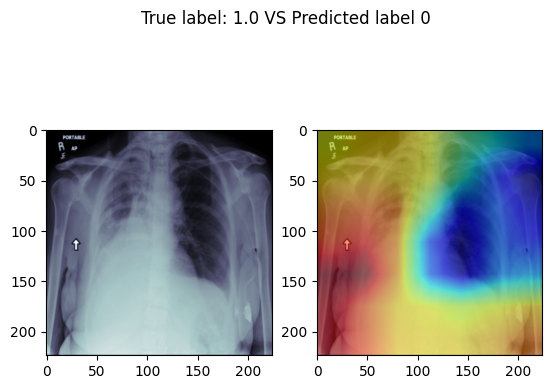

In [125]:
img,label=test_dataset[5]


print(img.shape)

activation_map,pred=cam(model,img.unsqueeze(0))

visualization(img, activation_map,pred,label.item())